<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [ ]:
def cross_entropy(target, pred):
    return -np.sum(target * np.log(pred))

In [ ]:
def rnn_cell(x, hprev, Wx, Wh):
    return np.tanh(Wx @ x + Wh @ hprev)

In [ ]:
def forward_pass(xs, h, Wx, Wh, Wy):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh)
        hs.append(h)

        y = softmax(Wy @ h)
        ys.append(y)

    return ys, hs

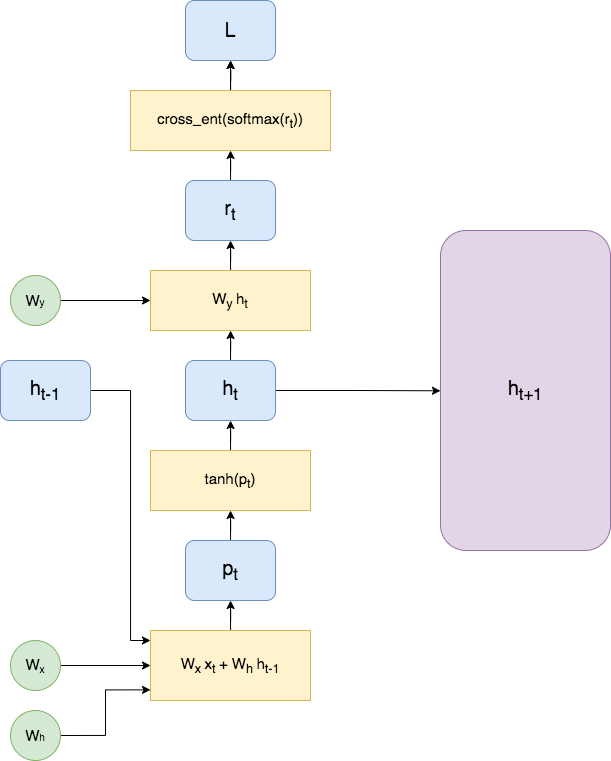

In [ ]:
def backward_pass(xs, ys, hs, ts):
    hnext = None
    dhnext = None

    for t, y in reversed(enumerate(ys)):
        h = hs[t].copy()
        x = xs[t].copy()

        dy = y.copy()
        dy[0, ts[t]] -= 1

        dWy += dy @ h.T

        dtanh = (1 - hnext * hnext)
        dh = (dtanh * Wh) @ dhnext + Wy @ dy
        
        dWx += dtanh @ x.T
        dWh += dtanh @ h.T